# NLP Project

## Download of the Dataset

In [1]:
import pandas as pd
import os

In [2]:
def get_labels_list(row: pd.Series) -> pd.Series:
    return [index for index, value in row.items() if value == 1]

def get_dataframe(data_folder: str, df_type: str) -> pd.DataFrame:
    assert df_type in ['training', 'validation', 'test'], 'Specify the `df_type` as either training, validation or test'
    
    arguments_df = pd.read_csv(os.path.join(data_folder, f'arguments-{df_type}.tsv'), sep='\t', header=0)
    labels_df = pd.read_csv(os.path.join(data_folder, f'labels-{df_type}.tsv'), sep='\t', header=0)
    
    arguments_df['Labels'] = labels_df.apply(lambda x: get_labels_list(x), axis=1)
    return arguments_df, labels_df

In [3]:
arguments_train_df, labels_train_df = get_dataframe('data', 'training')
arguments_val_df, labels_val_df = get_dataframe('data', 'validation')

In [4]:
print('Dataframe structure:')
arguments_train_df.head()

Dataframe structure:


,Argument ID,Conclusion,Stance,Premise,Labels
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...,[Security: societal]
1,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...,[Security: personal]
2,A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...,"[Power: dominance, Security: societal]"
3,A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...,"[Security: societal, Conformity: rules, Univer..."
4,A01008,We should ban factory farming,against,factory farming allows for the production of c...,"[Security: personal, Benevolence: caring, Univ..."


In [5]:
print(f'Number of rows: {len(arguments_train_df)}')

Number of rows: 5393


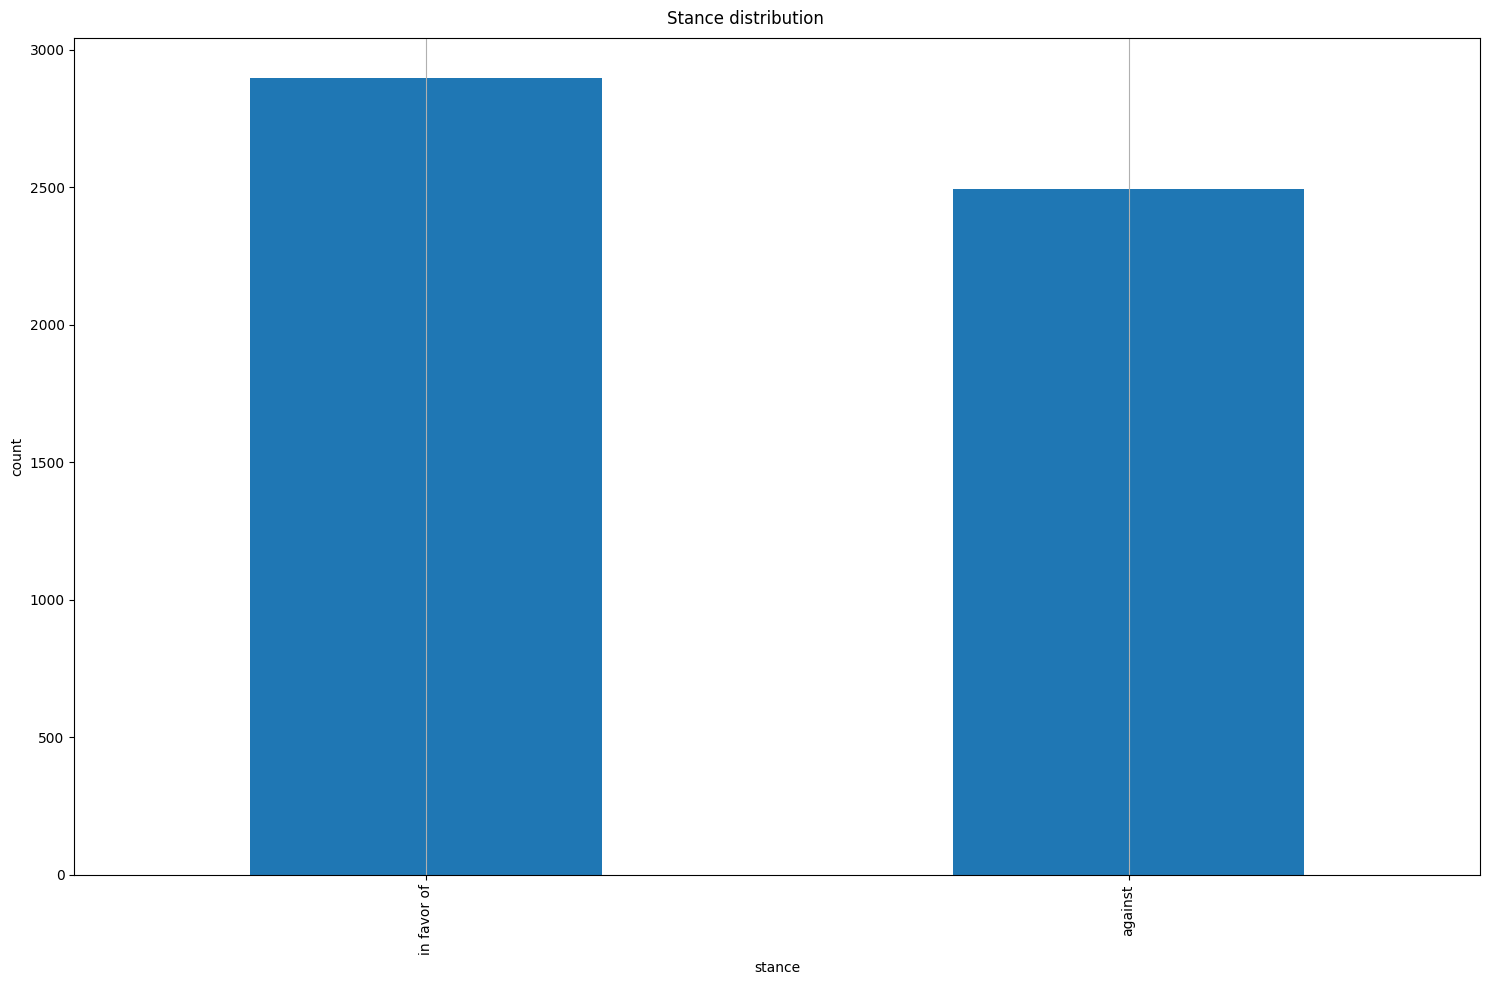

In [6]:
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(15, 10))
arguments_train_df.Stance.value_counts().plot(ax=ax, kind='bar')


# Show just the x grid
ax.grid(axis='x')

# set title and axis labels
plt.suptitle('Stance distribution')

ax.set_xlabel('stance')
ax.set_ylabel('count')

plt.tight_layout()


plt.show()

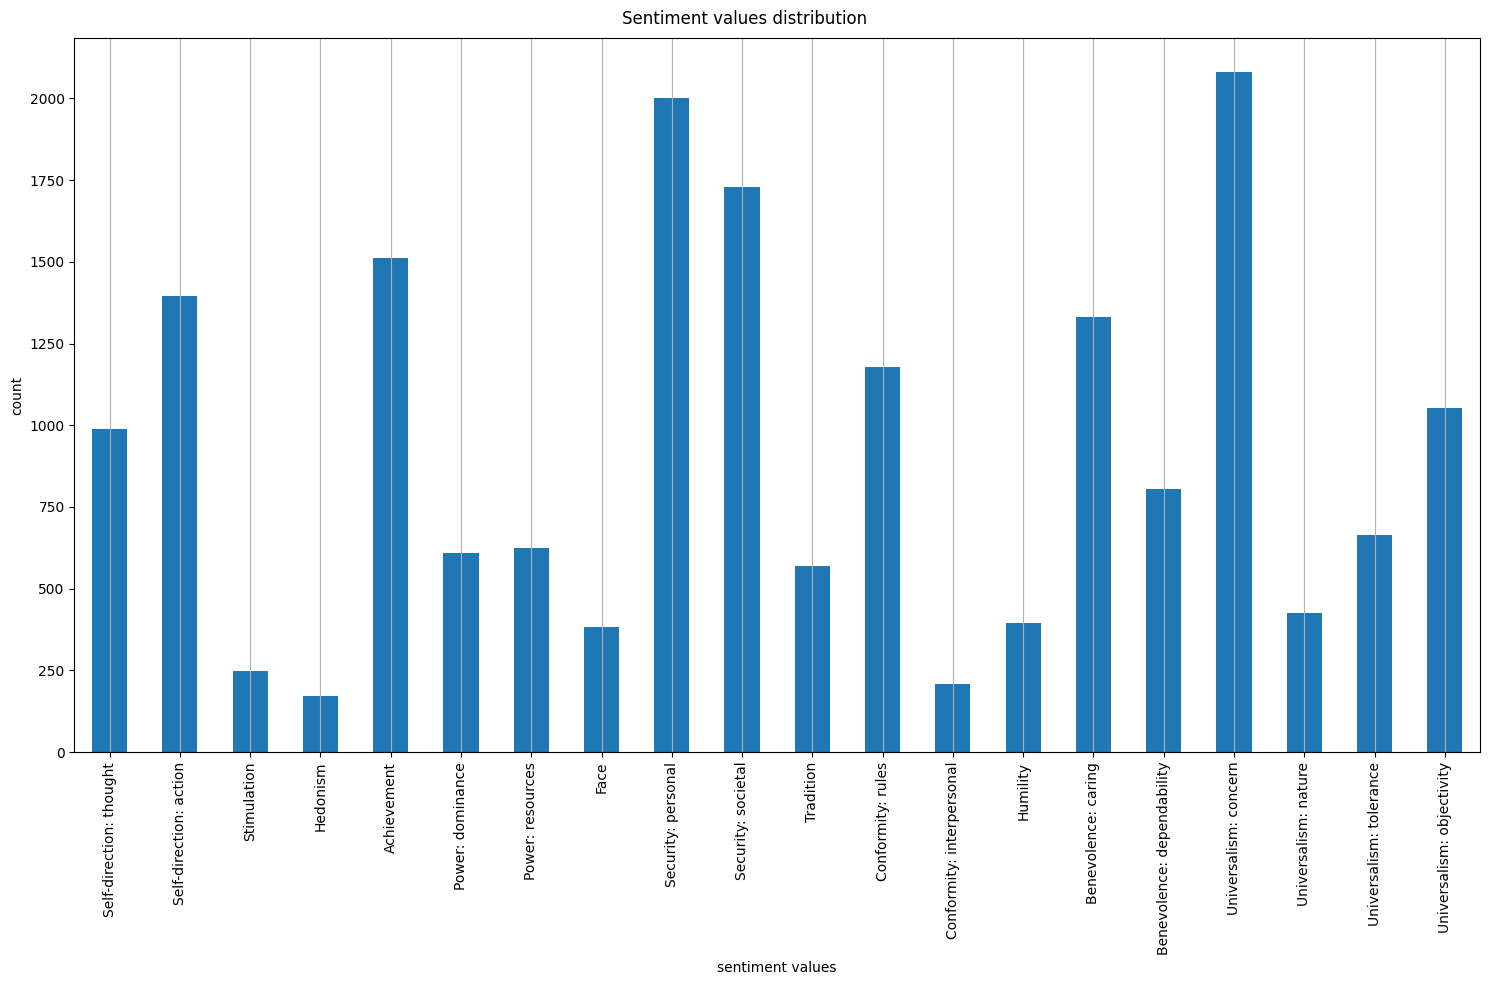

In [7]:
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(15, 10))
labels_train_df.drop('Argument ID', axis=1).sum().plot(ax=ax, kind='bar')


# Show just the x grid
ax.grid(axis='x')

# set title and axis labels
plt.suptitle('Sentiment values distribution')

ax.set_xlabel('sentiment values')
ax.set_ylabel('count')

plt.tight_layout()


plt.show()

In [8]:
import numpy as np

def plot_sequence_length_analysis(df: pd.DataFrame):
    """Analyse the length of the premises + stances + conclusions
    Parameters
    ----------
    df : DataFrame
        A pandas dataframe.
    """
    # Length of each training sentence
    train_sentences_lenghts = df.Premise.str.len() + df.Conclusion.str.len() + 1

    # Histogram of the sentences length distribution
    hist, bin_edges = np.histogram(train_sentences_lenghts, bins=np.max(train_sentences_lenghts) + 1, density=True) 
    # Cumulative distribution of the sentences length
    C = np.cumsum(hist)*(bin_edges[1] - bin_edges[0])

    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.plot(bin_edges[1:], hist)
    plt.title('Distribution of the sentence length across the train dataset')
    plt.xlabel('Sentence length')
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.plot(bin_edges[1:], C)
    plt.title('Comulative distribution of the sentence length across the train dataset')
    plt.xlabel('Sentence length')
    plt.grid()
    plt.show()

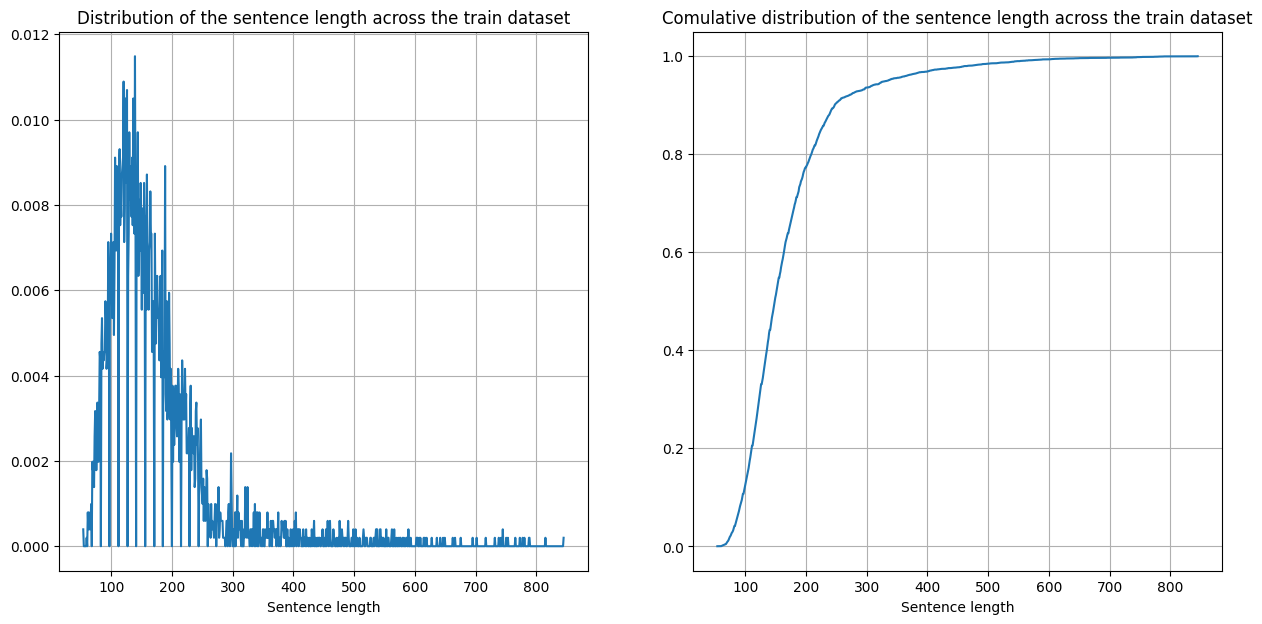

In [9]:
plot_sequence_length_analysis(arguments_train_df)

In [10]:
quantile_95 = (arguments_train_df.Premise.str.len() + arguments_train_df.Conclusion.str.len() + 1).quantile(.95, interpolation='nearest')

print(f'The 95th quantile of input lengths is: {quantile_95}')

The 95th quantile of input lengths is: 333


In [11]:
total_corpus = arguments_train_df.Conclusion.tolist() + arguments_train_df.Premise.tolist()

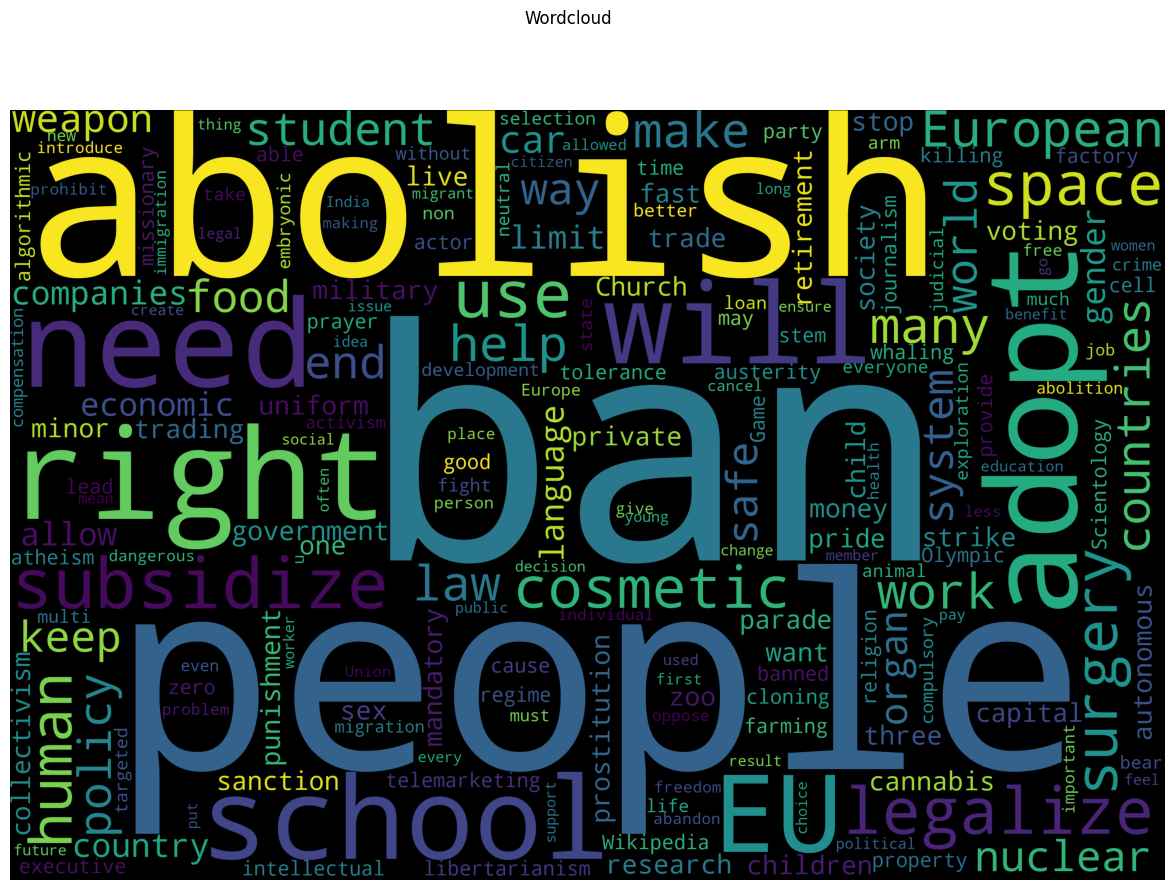

In [12]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

word_cloud = WordCloud(width=3000, height=2000, collocations=False, stopwords=STOPWORDS).generate(' '.join(total_corpus))
plt.figure(figsize=(15, 10))
plt.imshow(word_cloud)
plt.suptitle('Wordcloud') 
plt.axis("off")
plt.show()

In [13]:
# Importing the libraries needed
import pandas as pd
import torch
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer

c:\Users\riccardo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [15]:
len(labels_train_df.columns.to_list()[1:])

20

In [16]:
#label_to_number_dict = {l: i for i, l in enumerate(labels_train_df.columns.to_list()[1:])}
#number_to_label_dict = {i: l for l, i in label_to_number_dict.items()}

In [17]:
model_name = 'distilbert-base-cased'

In [18]:
from transformers import AutoTokenizer

# Defining some key variables that will be used later on in the training
MAX_LEN = quantile_95
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
EPOCHS = 1
LEARNING_RATE_BASE = 1e-05
LEARNING_RATE_HEAD = 1e-03
tokenizer = AutoTokenizer.from_pretrained(model_name, problem_type="multi_label_classification")


num_added_toks = tokenizer.add_tokens(['[FAV]', '[AGN]'], special_tokens=True) ##This line is updated

stance_encoder = {'in favor of': '[FAV]', 'against': '[AGN]'}

###The tokenizer has to be saved if it has to be reused
#tokenizer.save_pretrained(<output_dir>)

In [19]:
# Change from dataframe to numpy

class Triage(Dataset):
    def __init__(self, arguments_df: pd.DataFrame, labels_df: pd.DataFrame, tokenizer, max_len):
        self.len = len(arguments_df)
        self.arguments_data = arguments_df
        self.labels_data = labels_df
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        premise = self.arguments_data.Premise[index]
        conclusion = self.arguments_data.Conclusion[index]
        stance = stance_encoder[self.arguments_data.Stance[index]]
        #title = str(self.data.TITLE[index])
        #title = " ".join(title.split())
        
        input_text = premise + f' {stance} ' + conclusion
        
        inputs = self.tokenizer.encode_plus(
            input_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=False,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'labels': torch.tensor(self.labels_data.iloc[index][1:].to_list(), dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

In [20]:
# Creating the dataset and dataloader for the neural network
train_set = Triage(arguments_train_df, labels_train_df, tokenizer, MAX_LEN)
val_set = Triage(arguments_val_df, labels_val_df, tokenizer, MAX_LEN)

In [21]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(train_set, **train_params)
testing_loader = DataLoader(val_set, **test_params)

In [22]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 
'''
class DistillBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistillBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, len(labels_train_df.columns) - 1)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output'''

'\nclass DistillBERTClass(torch.nn.Module):\n    def __init__(self):\n        super(DistillBERTClass, self).__init__()\n        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")\n        self.pre_classifier = torch.nn.Linear(768, 768)\n        self.dropout = torch.nn.Dropout(0.3)\n        self.classifier = torch.nn.Linear(768, len(labels_train_df.columns) - 1)\n\n    def forward(self, input_ids, attention_mask):\n        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)\n        hidden_state = output_1[0]\n        pooler = hidden_state[:, 0]\n        pooler = self.pre_classifier(pooler)\n        pooler = torch.nn.ReLU()(pooler)\n        pooler = self.dropout(pooler)\n        output = self.classifier(pooler)\n        return output'

In [23]:
from transformers import AutoModelForSequenceClassification


model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(labels_train_df.columns) - 1,
    ignore_mismatched_sizes=True,
    problem_type="multi_label_classification")

model.resize_token_embeddings(len(tokenizer))

model.to(device)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifier.b

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28998, 768)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Li

In [24]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28998, 768)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Li

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(inputs,  targets.float())
        loss = self.alpha * (1 - torch.exp(-bce_loss)) ** self.gamma * bce_loss
        return loss

In [26]:

# Creating the loss function and optimizer
#loss_function = torch.nn.BCEWithLogitsLoss()
loss_function = FocalLoss()
optimizer = torch.optim.Adam(params=[
                {'params': model.distilbert.parameters(), 'lr': LEARNING_RATE_BASE},
                {'params': model.pre_classifier.parameters(), 'lr': LEARNING_RATE_HEAD},
                {'params': model.classifier.parameters(), 'lr': LEARNING_RATE_HEAD},
                {'params': model.dropout.parameters(), 'lr': LEARNING_RATE_HEAD}
            ])

In [27]:
# Function to calcuate the accuracy of the model

def calculate_accuracy(out, targets, threshold=.5):
    out = out.sigmoid()
    return ((out > threshold) == targets.bool()).float().mean().item()

In [28]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model

def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0

    for i, data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['labels'].to(device, dtype = torch.float32)
        
        outputs = model(ids, mask)
        
        loss = loss_function(outputs.logits, targets)
        tr_loss += loss.item()

        n_correct += calculate_accuracy(outputs.logits, targets)

        nb_tr_steps += 1
        
        if i % 5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct * 100)/nb_tr_steps 
            print(f'Training Loss per 5000 steps: {loss_step}')
            print(f'Training Accuracy per 5000 steps: {accu_step}')

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct * 100) / nb_tr_steps}')
    epoch_loss = tr_loss / nb_tr_steps
    epoch_accu = (n_correct * 100) / nb_tr_steps
    print(f"Training Loss Epoch {epoch}: {epoch_loss}")
    print(f"Training Accuracy Epoch {epoch}: {epoch_accu}")

    return 
     

In [29]:
for epoch in range(EPOCHS):
    model.train()
    train(epoch)

c:\Users\riccardo\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training Loss per 5000 steps: 0.17803747951984406
Training Accuracy per 5000 steps: 43.75
The Total Accuracy for Epoch 0: 85.51797745314416
Training Loss Epoch 0: 0.033610133429349924
Training Accuracy Epoch 0: 85.51797745314416


In [25]:
def valid(model, testing_loader):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask).squeeze()
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            #big_val, big_idx = torch.max(outputs.data, dim=1)
            #n_correct += calcuate_accu(big_idx, targets)
            
            # If no value is over threshold get maximum
            out = outputs.data >= .5
            #indices = out.nonzero()
            
            #big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calculate_accuracy(out, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    
    return epoch_accu

In [26]:
print('This is the validation section to print the accuracy and see how it performs')
print('Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch')

acc = valid(model, testing_loader)
print("Accuracy on test data = %0.2f%%" % acc)

This is the validation section to print the accuracy and see how it performs
Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch


RuntimeError: result type Float can't be cast to the desired output type Long